# Exploring Different CNN Architectures

## Importing and defining constants

In [139]:
import os
import time
import math

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers


In [140]:
## Defining constants

DATASET = "./dataset"

TRAIN_DIR = DATASET + "/train"
TEST_DIR = DATASET + "/test"

TRAIN_IMAGES = os.listdir(TRAIN_DIR + '/images')
TRAIN_IMAGES.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
TRAIN_IMAGES = [os.path.join(TRAIN_DIR + '/images', img) for img in TRAIN_IMAGES] # Full image paths

TRAIN_ANNOTATIONS = os.listdir(TRAIN_DIR + '/labels')
TRAIN_ANNOTATIONS.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
TRAIN_ANNOTATIONS = [os.path.join(TRAIN_DIR + '/labels', label) for label in TRAIN_ANNOTATIONS]  # Full label paths


TEST_IMAGES = os.listdir(TEST_DIR + '/images')
TEST_ANNOTATIONS = os.listdir(TEST_DIR + '/labels')

## Visualizing and Experimenting on Data Processing

In [141]:
def visualize(image_path, bbox_df, figsize=(10, 10)):

    img = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=figsize)

    ax.imshow(img)
    
    height, width, _ = img.shape
    
    for row in bbox_df.itertuples(index=False):

        x_min, y_min, x_max, y_max = row
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.axis('off')
    plt.show()

C:\Users\PMLS\AppData\Local\Temp\ipykernel_6280\1045550048.py:13: UserWarning: loadtxt: input contained no data: "./dataset/train/labels\IMG_31.txt"
  label = np.loadtxt(label_path, delimiter=" ")


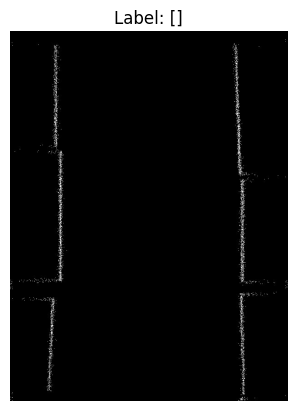

In [145]:
def load_image(image_path, label_path):
    # Convert the tensors to strings
    image_path = image_path.numpy().decode("utf-8")
    label_path = label_path.numpy().decode("utf-8")

    # Process image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Load as grayscale (1 channel)
    image = tf.image.resize(image, [800, 600])  # Resize to 800x600
    image = image / 255.0  # Normalize to [0, 1]

    # Process label
    label = np.loadtxt(label_path, delimiter=" ")
    
    # Ensure the label has a consistent shape
    # This is an example; adjust according to your specific use case
    if len(label.shape) == 1:
        label = np.expand_dims(label, axis=0)  # Make it 2D if it's 1D
    elif label.shape[0] > 1:
        # Consider adding padding or truncation logic here if necessary
        label = label[:1]  # Adjust this as needed for your use case
    
    return image, label


# Example to load and display a single image and its label
image_tensor = tf.convert_to_tensor(TRAIN_IMAGES[31])
label_tensor = tf.convert_to_tensor(TRAIN_ANNOTATIONS[31])
image, label = load_image(image_tensor, label_tensor)

# Display the image
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


## Creating Dataset

In [146]:
image_dataset = tf.data.Dataset.from_tensor_slices(TRAIN_IMAGES)
label_dataset = tf.data.Dataset.from_tensor_slices(TRAIN_ANNOTATIONS)

dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# Apply the load_image function to process the dataset
dataset = dataset.map(lambda image_path, label_path: tf.py_function(
    func=load_image, 
    inp=[image_path, label_path], 
    Tout=[tf.float32, tf.float32]
))

batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Loading Example

In [147]:
example = dataset.as_numpy_iterator().next()

C:\Users\PMLS\AppData\Local\Temp\ipykernel_6280\1045550048.py:13: UserWarning: loadtxt: input contained no data: "./dataset/train/labels\IMG_31.txt"
  label = np.loadtxt(label_path, delimiter=" ")


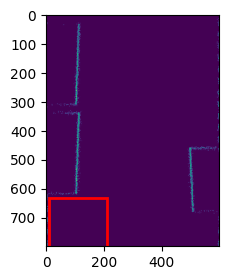

In [148]:
fig, ax = plt.subplots(figsize=(3,3))
x_min, y_min, x_max, y_max = example[1][0][0]
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.imshow(example[0][0])

## Defining Model Architecture

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ux-vHcQdqTFkdfETYCz-5Q.jpeg)

In [154]:
INPUT_SHAPE = (800, 600, 1)

input_layer = tf.keras.layers.Input(INPUT_SHAPE)

#create the base layers
base_layers = layers.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(1, name='cl_head')(classifier_branch) 

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [155]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

In [157]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 800, 600,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_1 (Rescaling)    │ (None, 800, 600,  │          0 │ input_layer_5[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_2 (Conv2D)       │ (None, 800, 600,  │        160 │ bl_1[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_3 (MaxPooling2D) │ (None, 400, 300,  │          0 │ bl_2[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_4 (Conv2D)       │ (None, 400, 300,  │      4,640 │ bl_3[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_5 (MaxPooling2D) │ (None, 200, 150,  │          0 │ bl_4[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_6 (Conv2D)       │ (None, 200, 150,  │     18,496 │ bl_5[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_7 (MaxPooling2D) │ (None, 100, 75,   │          0 │ bl_6[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_8 (Flatten)      │ (None, 480000)    │          0 │ bl_7[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1 (Dense)        │ (None, 128)       │ 61,440,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2 (Dense)        │ (None, 64)        │      8,256 │ bb_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_1 (Dense)        │ (None, 128)       │ 61,440,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_3 (Dense)        │ (None, 32)        │      2,080 │ bb_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_head (Dense)     │ (None, 1)         │        129 │ cl_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_head (Dense)     │ (None, 4)         │        132 │ bb_3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,914,149 (468.88 MB)

 Trainable params: 122,914,149 (468.88 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
losses = {"cl_head":tf.keras.losses.BinaryCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [165]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])